# 🏅 Predicting Olympic Medals using Linear Regression

This project builds a **Machine Learning model** to predict the number of medals won by a country in the Olympics.

We use the dataset `teams.csv` which contains information about Olympic teams such as:
- Number of athletes
- Average age
- Previous medals
- Medals won in the current Olympics

We will:
1. Load and explore the dataset
2. Clean missing values
3. Split the data into **training** and **testing** sets (time-based split)
4. Train a **Linear Regression model**
5. Evaluate performance using **MAE** and **R²**
6. Analyze prediction errors


In [ ]:
# === 1) Import libraries ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


## 2. Load and explore the dataset

In [2]:
teams = pd.read_csv(r"C:\Users\User\Documents\python machine learning\teams.csv")
teams = teams[["team", "country", "year", "athletes", "age", "prev_medals", "medals"]]

print("Dataset shape:", teams.shape)
teams.head()

Dataset shape: (2144, 7)


,team,country,year,athletes,age,prev_medals,medals
0,AFG,Afghanistan,1964,8,22.0,0.0,0
1,AFG,Afghanistan,1968,5,23.2,0.0,0
2,AFG,Afghanistan,1972,8,29.0,0.0,0
3,AFG,Afghanistan,1980,11,23.6,0.0,0
4,AFG,Afghanistan,2004,5,18.6,0.0,0


### Correlations with target variable (`medals`)

medals         1.000000
prev_medals    0.920048
athletes       0.840817
age            0.025096
year          -0.021603
Name: medals, dtype: float64


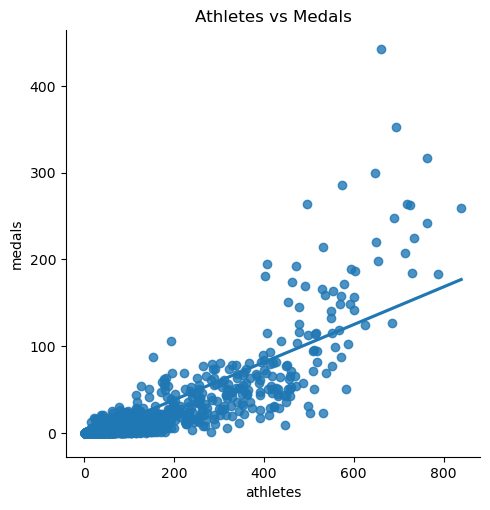

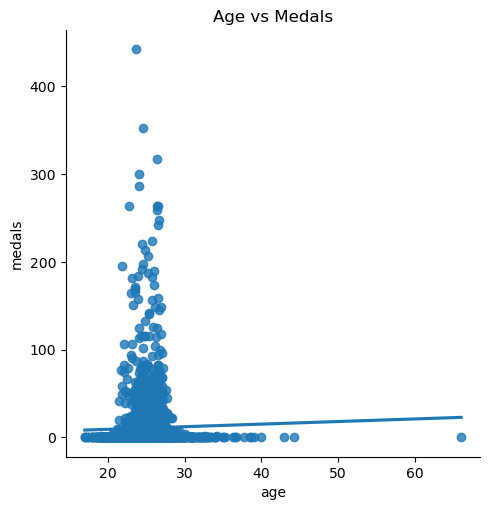

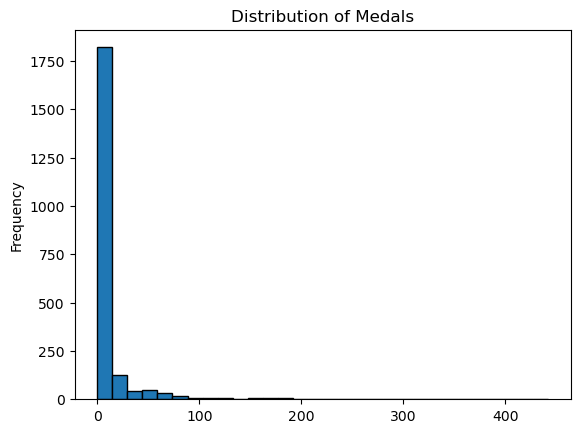

In [3]:
corr = teams.corr(numeric_only=True)["medals"].sort_values(ascending=False)
print(corr)

# Plot correlations
sns.lmplot(x='athletes', y='medals', data=teams, fit_reg=True, ci=None)
plt.title("Athletes vs Medals")
plt.show()

sns.lmplot(x='age', y='medals', data=teams, fit_reg=True, ci=None)
plt.title("Age vs Medals")
plt.show()

teams["medals"].plot.hist(bins=30, edgecolor='black')
plt.title("Distribution of Medals")
plt.show()

## 3. Handle Missing Values

In [4]:
print("Rows with missing values:", teams.isnull().any(axis=1).sum())
teams = teams.dropna()
print("Shape after cleaning:", teams.shape)

Rows with missing values: 130
Shape after cleaning: (2014, 7)


## 4. Train-Test Split (time-based)
- Training set: years < 2012
- Testing set: years ≥ 2012

In [5]:
train = teams[teams["year"] < 2012].copy()
test  = teams[teams["year"] >= 2012].copy()
print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (1609, 7) Test shape: (405, 7)


## 5. Train Linear Regression Model

In [6]:
predictors = ["athletes", "prev_medals"]
reg = LinearRegression()
reg.fit(train[predictors], train["medals"])

print("Model coefficients:")
for name, coef in zip(predictors, reg.coef_):
    print(f"  {name:12s}: {coef:.4f}")
print("Intercept     :", reg.intercept_)

Model coefficients:
  athletes    : 0.0717
  prev_medals : 0.7506
Intercept     : -2.1420694641161138


## 6. Predictions on Test Data

In [7]:
pred = reg.predict(test[predictors])

# Fix negative values and round to integers
pred_fixed = np.maximum(pred, 0).round()
test["predictions"] = pred_fixed

test[["team", "year", "athletes", "prev_medals", "medals", "predictions"]].head(10)

,team,year,athletes,prev_medals,medals,predictions
6,AFG,2012,6,1.0,1,0.0
7,AFG,2016,3,1.0,0,0.0
24,ALB,2012,10,0.0,0,0.0
25,ALB,2016,6,0.0,0,0.0
37,ALG,2012,39,2.0,1,2.0
38,ALG,2016,74,1.0,2,4.0
48,AND,2012,6,0.0,0,0.0
49,AND,2016,4,0.0,0,0.0
57,ANG,2012,35,0.0,0,0.0
58,ANG,2016,26,0.0,0,0.0


## 7. Model Evaluation (MAE, R²)

In [8]:
mae = mean_absolute_error(test["medals"], pred_fixed)
r2  = r2_score(test["medals"], pred_fixed)
print("MAE:", mae)
print("R² :", r2)

MAE: 3.2987654320987656
R² : 0.9210409414691608


## 8. Country Examples (USA, India)

In [9]:
for code in ["USA", "IND"]:
    sample = test[test["team"] == code][["year","athletes","prev_medals","medals","predictions"]]
    if not sample.empty:
        print(f"\nResults for {code}:")
        display(sample.sort_values("year"))


Results for USA:


,year,athletes,prev_medals,medals,predictions
2053,2012,689,317.0,248,285.0
2054,2016,719,248.0,264,236.0



Results for IND:


,year,athletes,prev_medals,medals,predictions
907,2012,95,3.0,6,7.0
908,2016,130,6.0,2,12.0


## 9. Error Analysis per Team

team
FRA    0.024289
CAN    0.050844
NZL    0.071349
RUS    0.081841
ITA    0.119537
         ...   
PHI    3.563248
JOR    4.065175
BDI    4.136878
AUT    4.257950
NIG    4.423693
Name: medals, Length: 97, dtype: float64

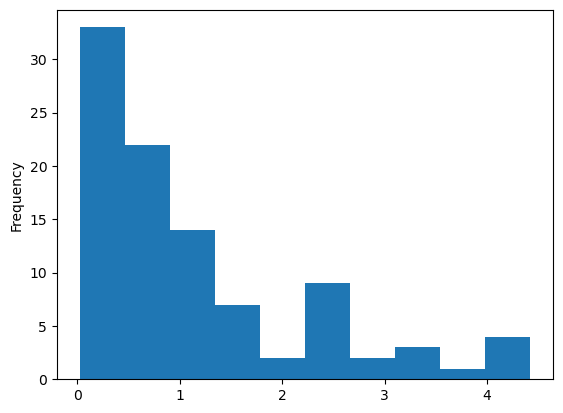

In [13]:
errors = (test["medals"] - pred).abs()
error_by_team = errors.groupby(test["team"]).mean()
medals_by_team = test["medals"].groupby(test["team"]).mean()
error_ratio = error_by_team / medals_by_team
error_ratio = error_ratio[np.isfinite(error_ratio)]
error_ratio.plot.hist()
error_ratio.sort_values()

# ✅ Conclusion
- The model uses **athletes** and **previous medals** to predict Olympic medals.
- It achieves an **MAE of ~3 medals** on the test set.
- The coefficient for `prev_medals` is much stronger than for `athletes`, which makes sense: past performance is a strong predictor.
- Limitations: Linear regression may output negative or fractional predictions (we corrected that by clipping & rounding). Other models like **Poisson Regression** or **Gradient Boosting** could be tested.

This notebook provides a complete pipeline: from raw data → preprocessing → modeling → evaluation → error analysis.